## Задача: Поиск фейковых отзывов
Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара и отражаются в виде рейтинга товара в звездах с текстовым комментарием.
 
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
* положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
* отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.

#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.

#### Этапы разработки решения
* --> L0 - Проработка и формализация задачи, определение таргета	определен таргет, определена мл задача (2 недели)
* --> L1 - Первичный анализ данных, очищение данных	проведен EDA, данные изучены, убраны все выбросы, пропуски и лишние данные (1 неделя)
* L2 - Ресерч проблематики, определение набора подходящих решений	проведен поиск решений среди научных работ/статей, отобраны наиболее оптимальные решения и сформирована итоговая архитектура решения (1 неделя)	
* L3 - Формирование обучающей выборки, проектирование валидации	сформирована обучающая, тестовая и валидационная выборки, построен пайплайн валидации (1 неделя)
* L4 - Разработка бейзлайна и реализация выбранного решения	готов бейзлайн и первая реализация выбранного решения (2 недели)
* L5 - Оценка решения, оптимизация алгоритма	проведен анализ оптимальной метрики для оценки решения, проведена оценка бейзлайна и целевого решения, подобраны параметры решения улучшающие метрики (1 неделя)
* L6 - Приведение решения в читабельный вид (аналог вывода в продакшн) улучшена структура кода, написаны комментарии (1 неделя)




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from multiprocessing import Pool
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv("wb_school_task_2.csv")
df.sample(10)

id1                   id2                   id3  \
1425   6166556738684775971  17014217512214378604  15784563364140581349   
320    7795503044448050796   1338883236496361504  18079360616650557094   
2625   8773558373558250666  13443263366962188618  14406840772366558829   
1752  10209987841578936425  11862862597086892517    960609968523426271   
1936   6693319202098206255   3922273748410779249  14798831147677895762   
2654  11620090129254325493   5339959275519284473  13303576206956409198   
802    8989257716062345391  17384656757382777856  11828389542295011237   
1709  13784869943618091422   9460906736640641382  12352834126591843936   
1723  13823627268069149155   3345344880097563888  14918306419713499452   
2973   2758868307667834062  12200350201681019251  12804658456659196855   

                                                   text  f1  f2        f3  \
1425                             Качество соответствует   8   8  5.000000   
320   Спасибо всем очень красиво упаковано,конверт о...   2   2  5.000000   
2625  Очень маленькая чаша,написано что на 2-4 челов...   1   1  1.000000   
1752  Очень классная игрушка, уточки изумительные🐤🫧🛁...  29  27  4.517241   
1936                                Всё хорошо работает  16  15  4.812500   
2654                 Конфеты супер. Заказ пришёл быстро  13  13  5.000000   
802                         Норм. В ДЕЛЕ ВРОДЕ  ХОРОШИЙ  30  29  4.700000   
1709                           Мёд отличный, ароматный!   3   3  5.000000   
1723                                    цвет не подошёл   1   1  4.000000   
2973                          Работает посмотрим дальше   1   1  4.000000   

         f4    f5        f6   f7   f8  label  
1425   9648   813  4.776327   15   15      0  
320      11     8  5.000000    9   12      0  
2625     21     6  4.238095    0    1      1  
1752    297    75  4.747475   63  161      0  
1936     64    20  4.125000   21   27      0  
2654    835    74  4.645509  133  163      0  
802     203    35  4.418719   94  104      0  
1709    109    48  4.513761   64   91      0  
1723  20419  4690  4.678780   12   17      0  
2973   2256   447  4.810727    1    1      0

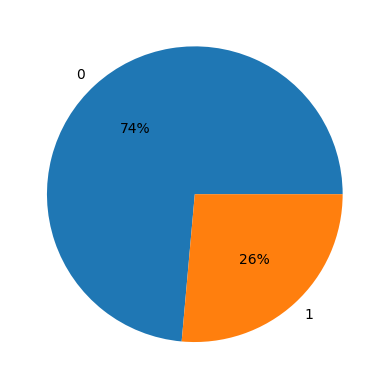

In [3]:
plt.pie(df.label.value_counts(), labels=df.label.unique(), autopct='%1.f%%')
plt.show()

In [4]:
# проверим на пропуски
df.isna().mean()

id1      0.0
id2      0.0
id3      0.0
text     0.0
f1       0.0
f2       0.0
f3       0.0
f4       0.0
f5       0.0
f6       0.0
f7       0.0
f8       0.0
label    0.0
dtype: float64

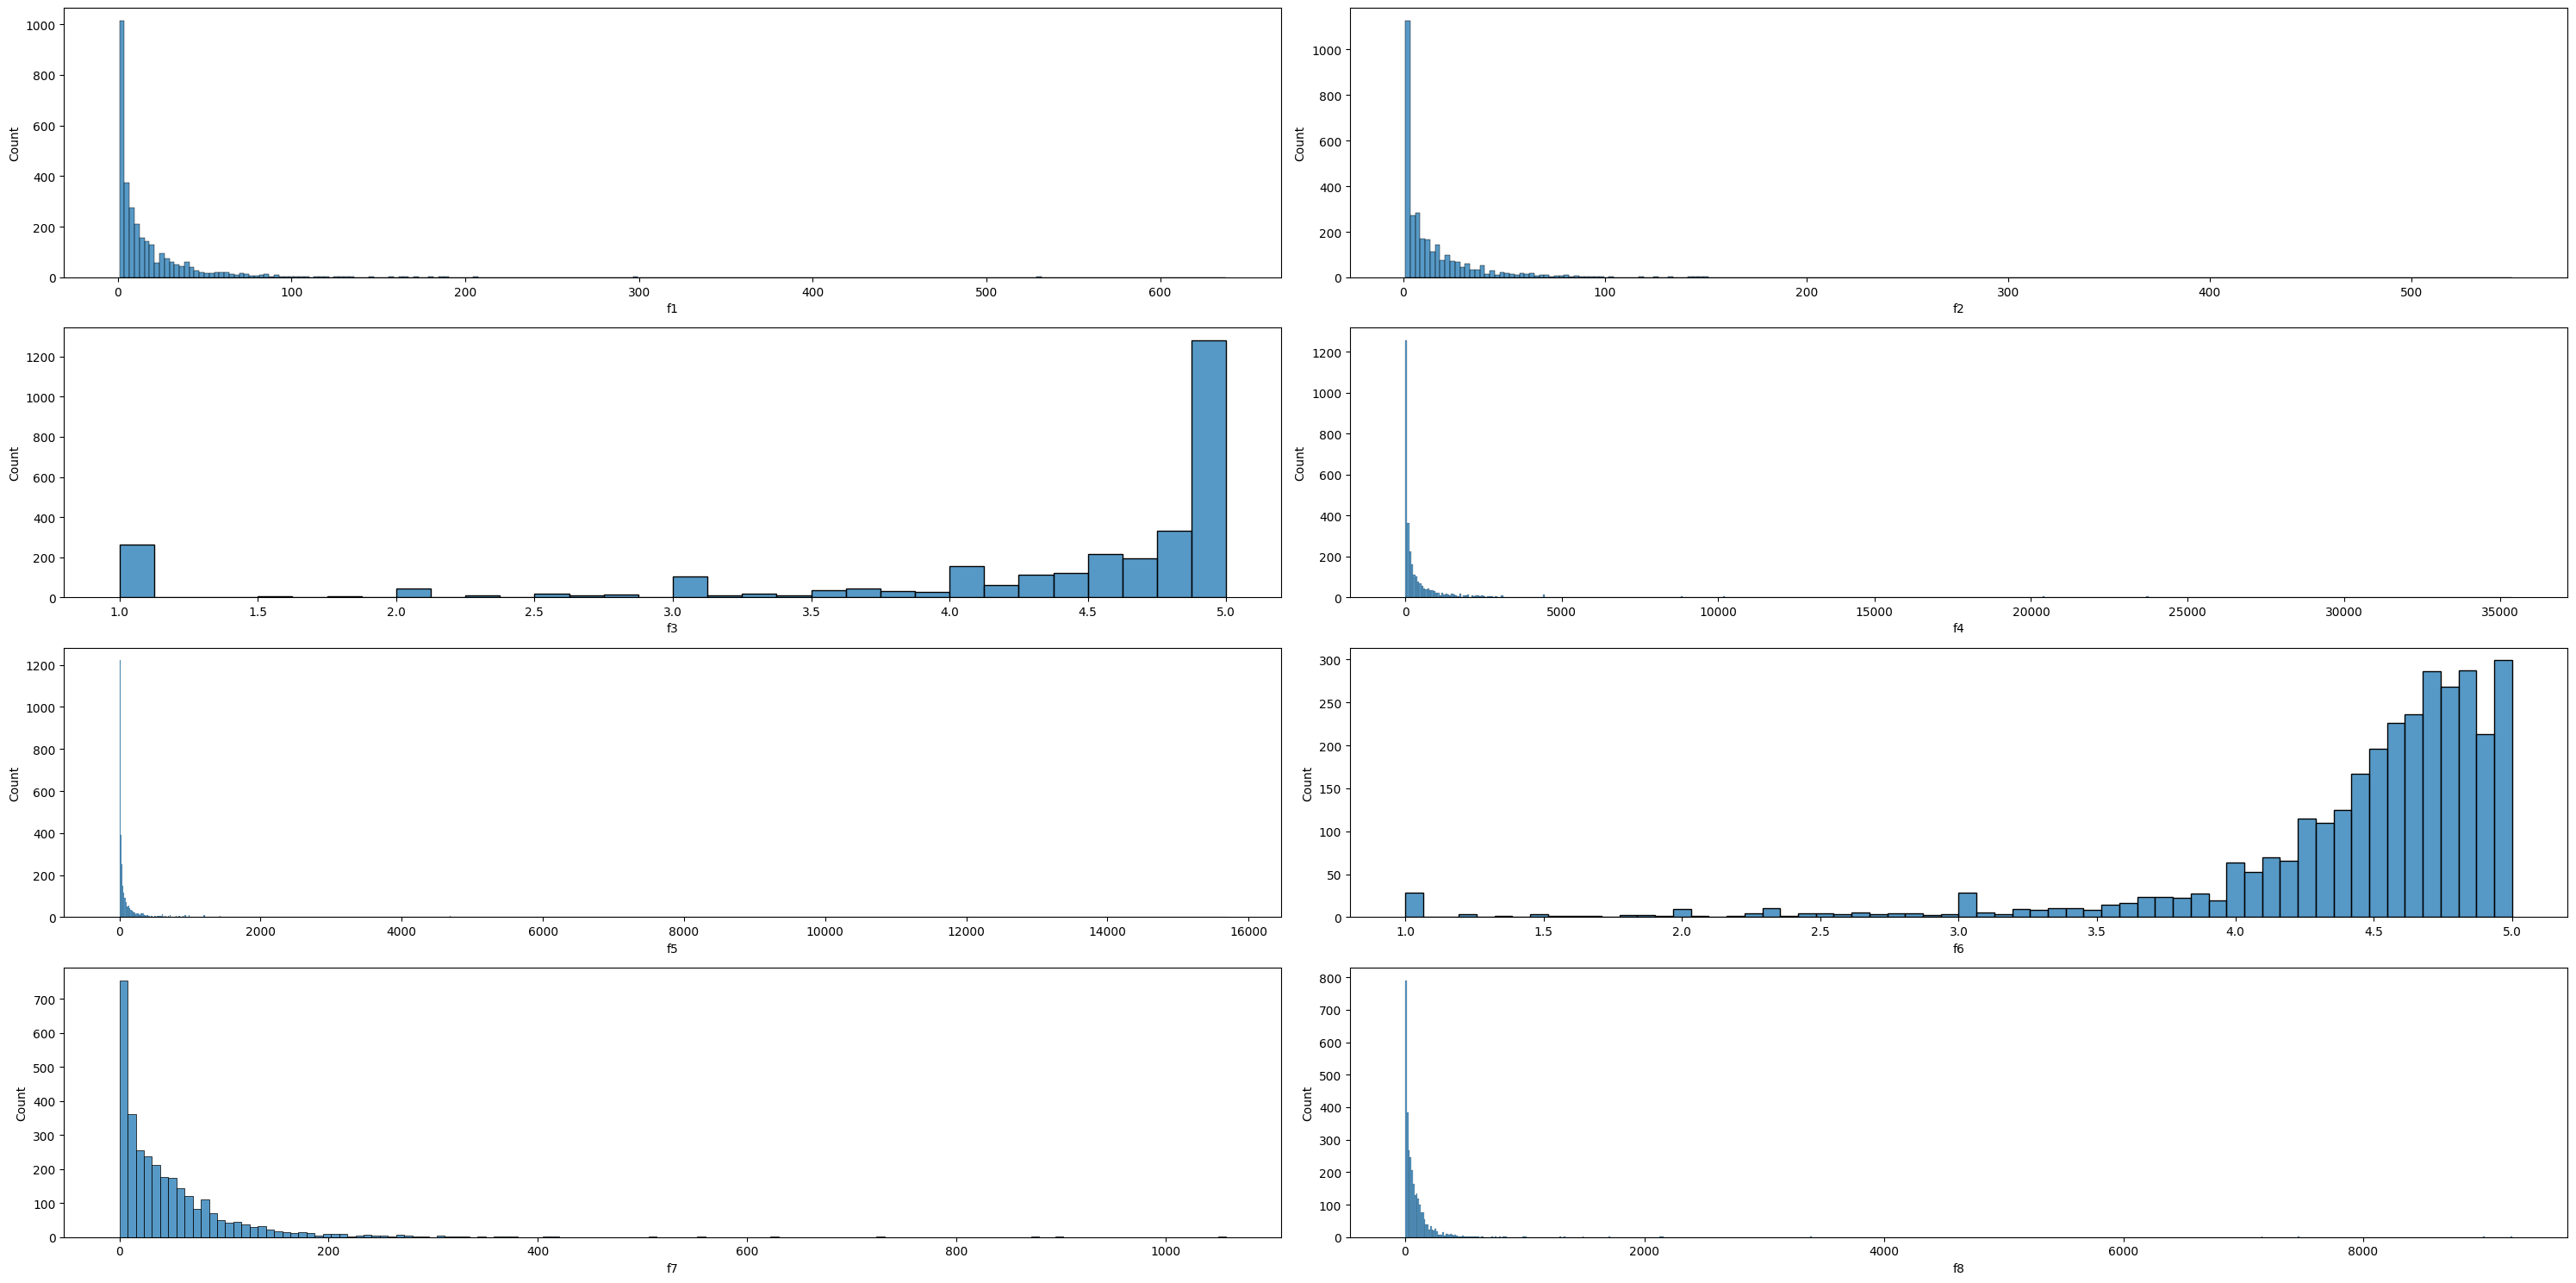

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(30, 15))
sns.histplot(data=df.f1, ax=axes[0,0])
sns.histplot(data=df.f2, ax=axes[0,1])
sns.histplot(data=df.f3, ax=axes[1,0])
sns.histplot(data=df.f4, ax=axes[1,1])
sns.histplot(data=df.f5, ax=axes[2,0])
sns.histplot(data=df.f6, ax=axes[2,1])
sns.histplot(data=df.f7, ax=axes[3,0])
sns.histplot(data=df.f8, ax=axes[3,1])
plt.tight_layout()
plt.show()

f3, f6 - усредненные оценки

In [6]:
# Пользователи
df.id1.nunique()

3049

In [7]:
# Товары
df.id2.nunique()

3006

In [8]:
# Типы товаров
df.id3.nunique()

978

In [9]:
df['sym_len'] = df.text.apply(len)
df['word_len'] = df.text.apply(lambda x: len(x.split()))

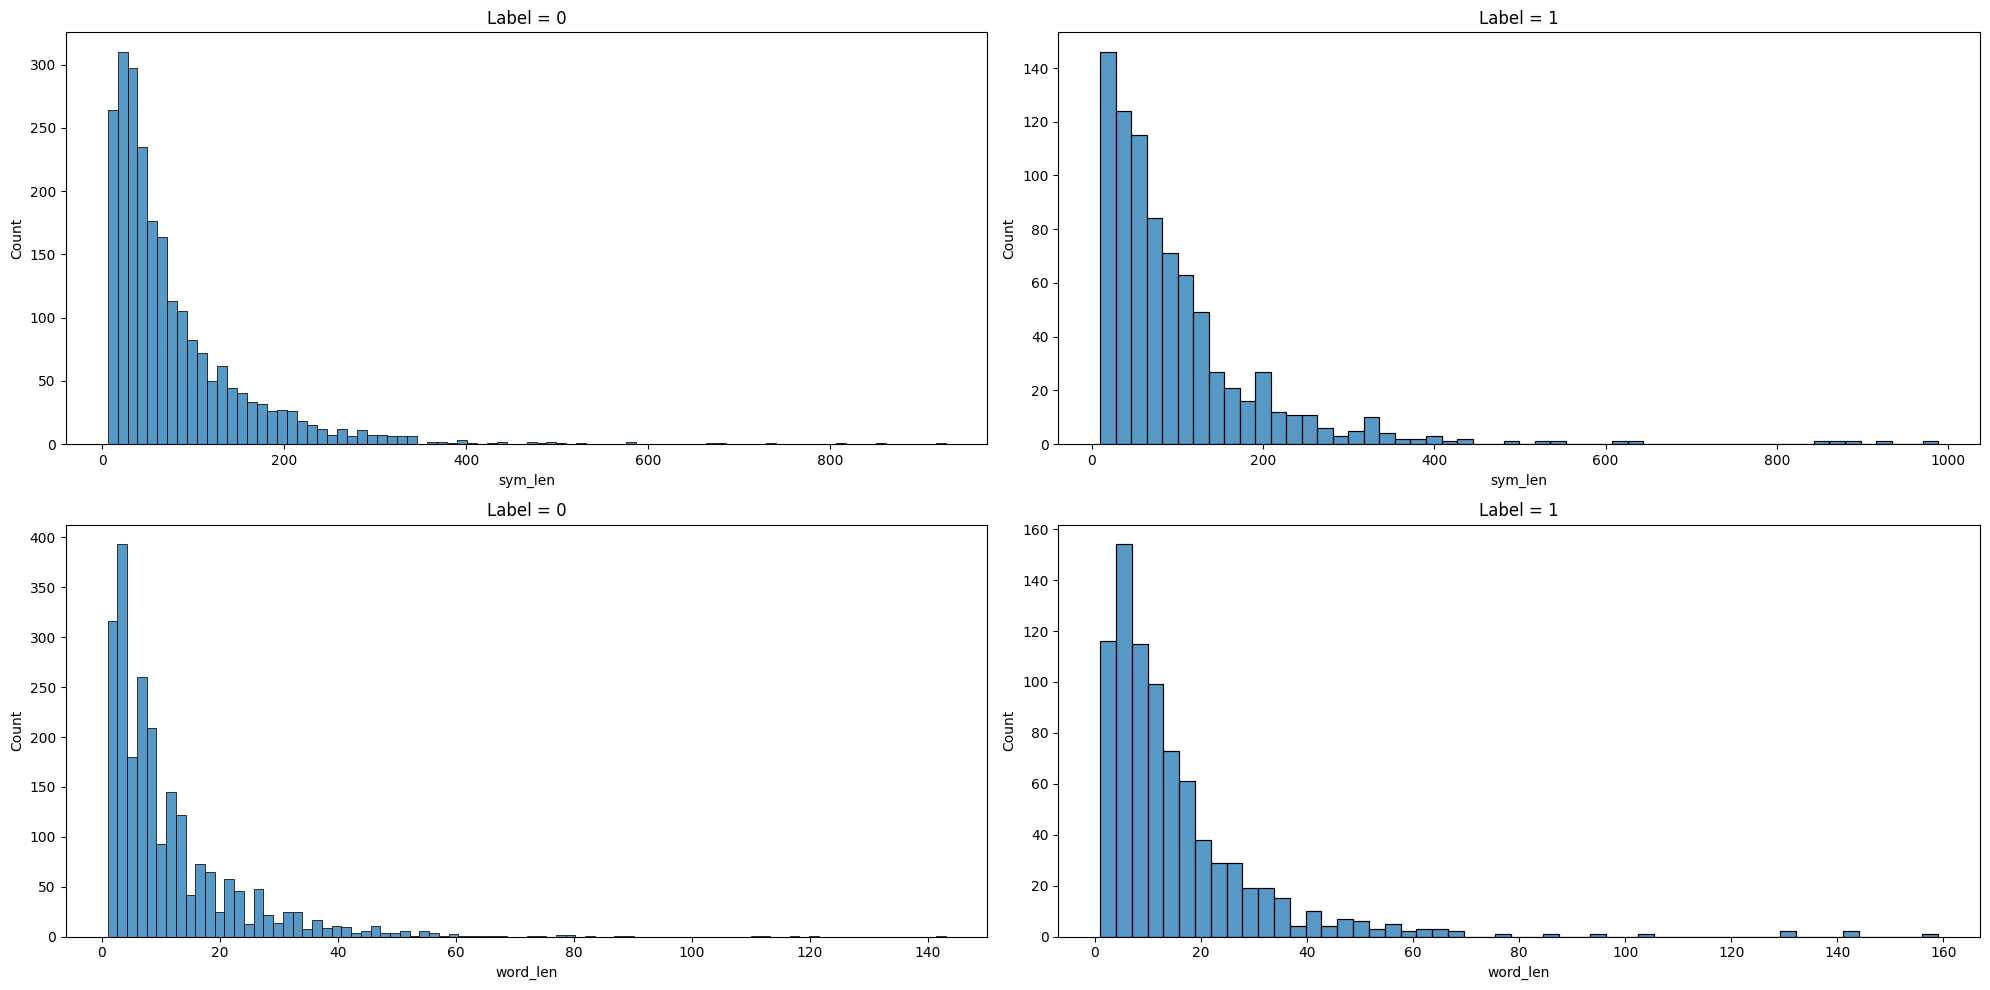

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.histplot(data=df[df["label"] == 0].sym_len, ax=axes[0, 0]).set(title='Label = 0')
sns.histplot(data=df[df["label"] == 1].sym_len, ax=axes[0, 1]).set(title='Label = 1')
sns.histplot(data=df[df["label"] == 0].word_len, ax=axes[1, 0]).set(title='Label = 0')
sns.histplot(data=df[df["label"] == 1].word_len, ax=axes[1, 1]).set(title='Label = 1')
plt.tight_layout()
plt.show()

Распределения признаков имеют очень длинные хвосты, поэтому заведем их в логарифмированном виде

In [11]:
df['sym_len'] = np.log(df['sym_len'])
df['word_len'] = np.log(df['word_len'])

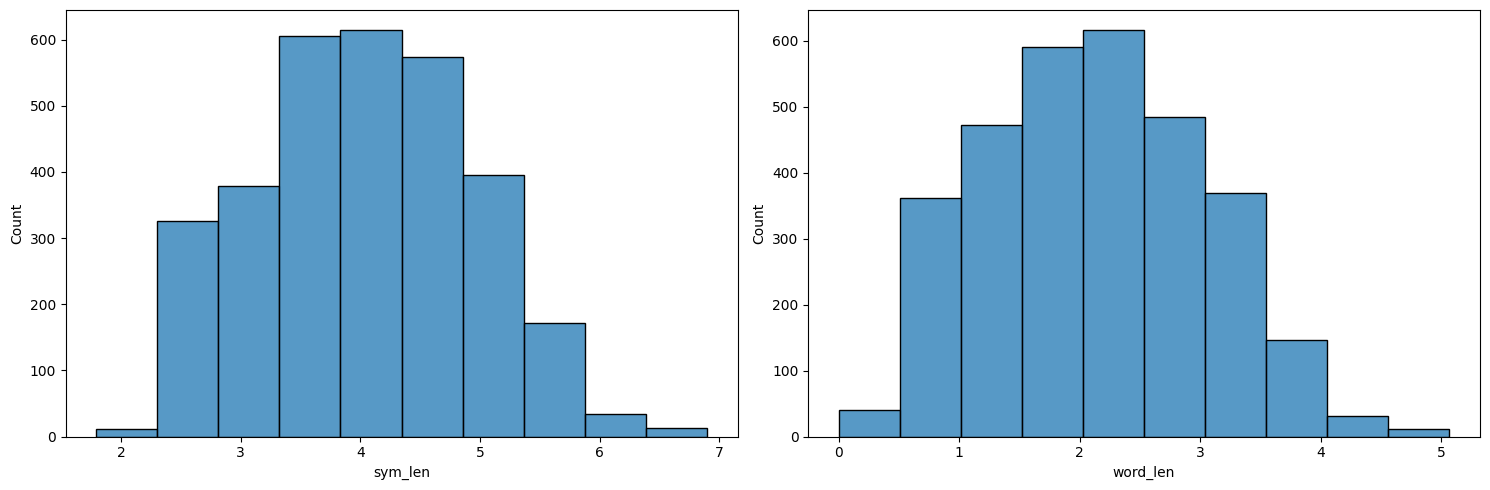

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df.sym_len, ax=axes[0], bins=10)
sns.histplot(data=df.word_len, ax=axes[1], bins=10)
plt.tight_layout()
plt.show()

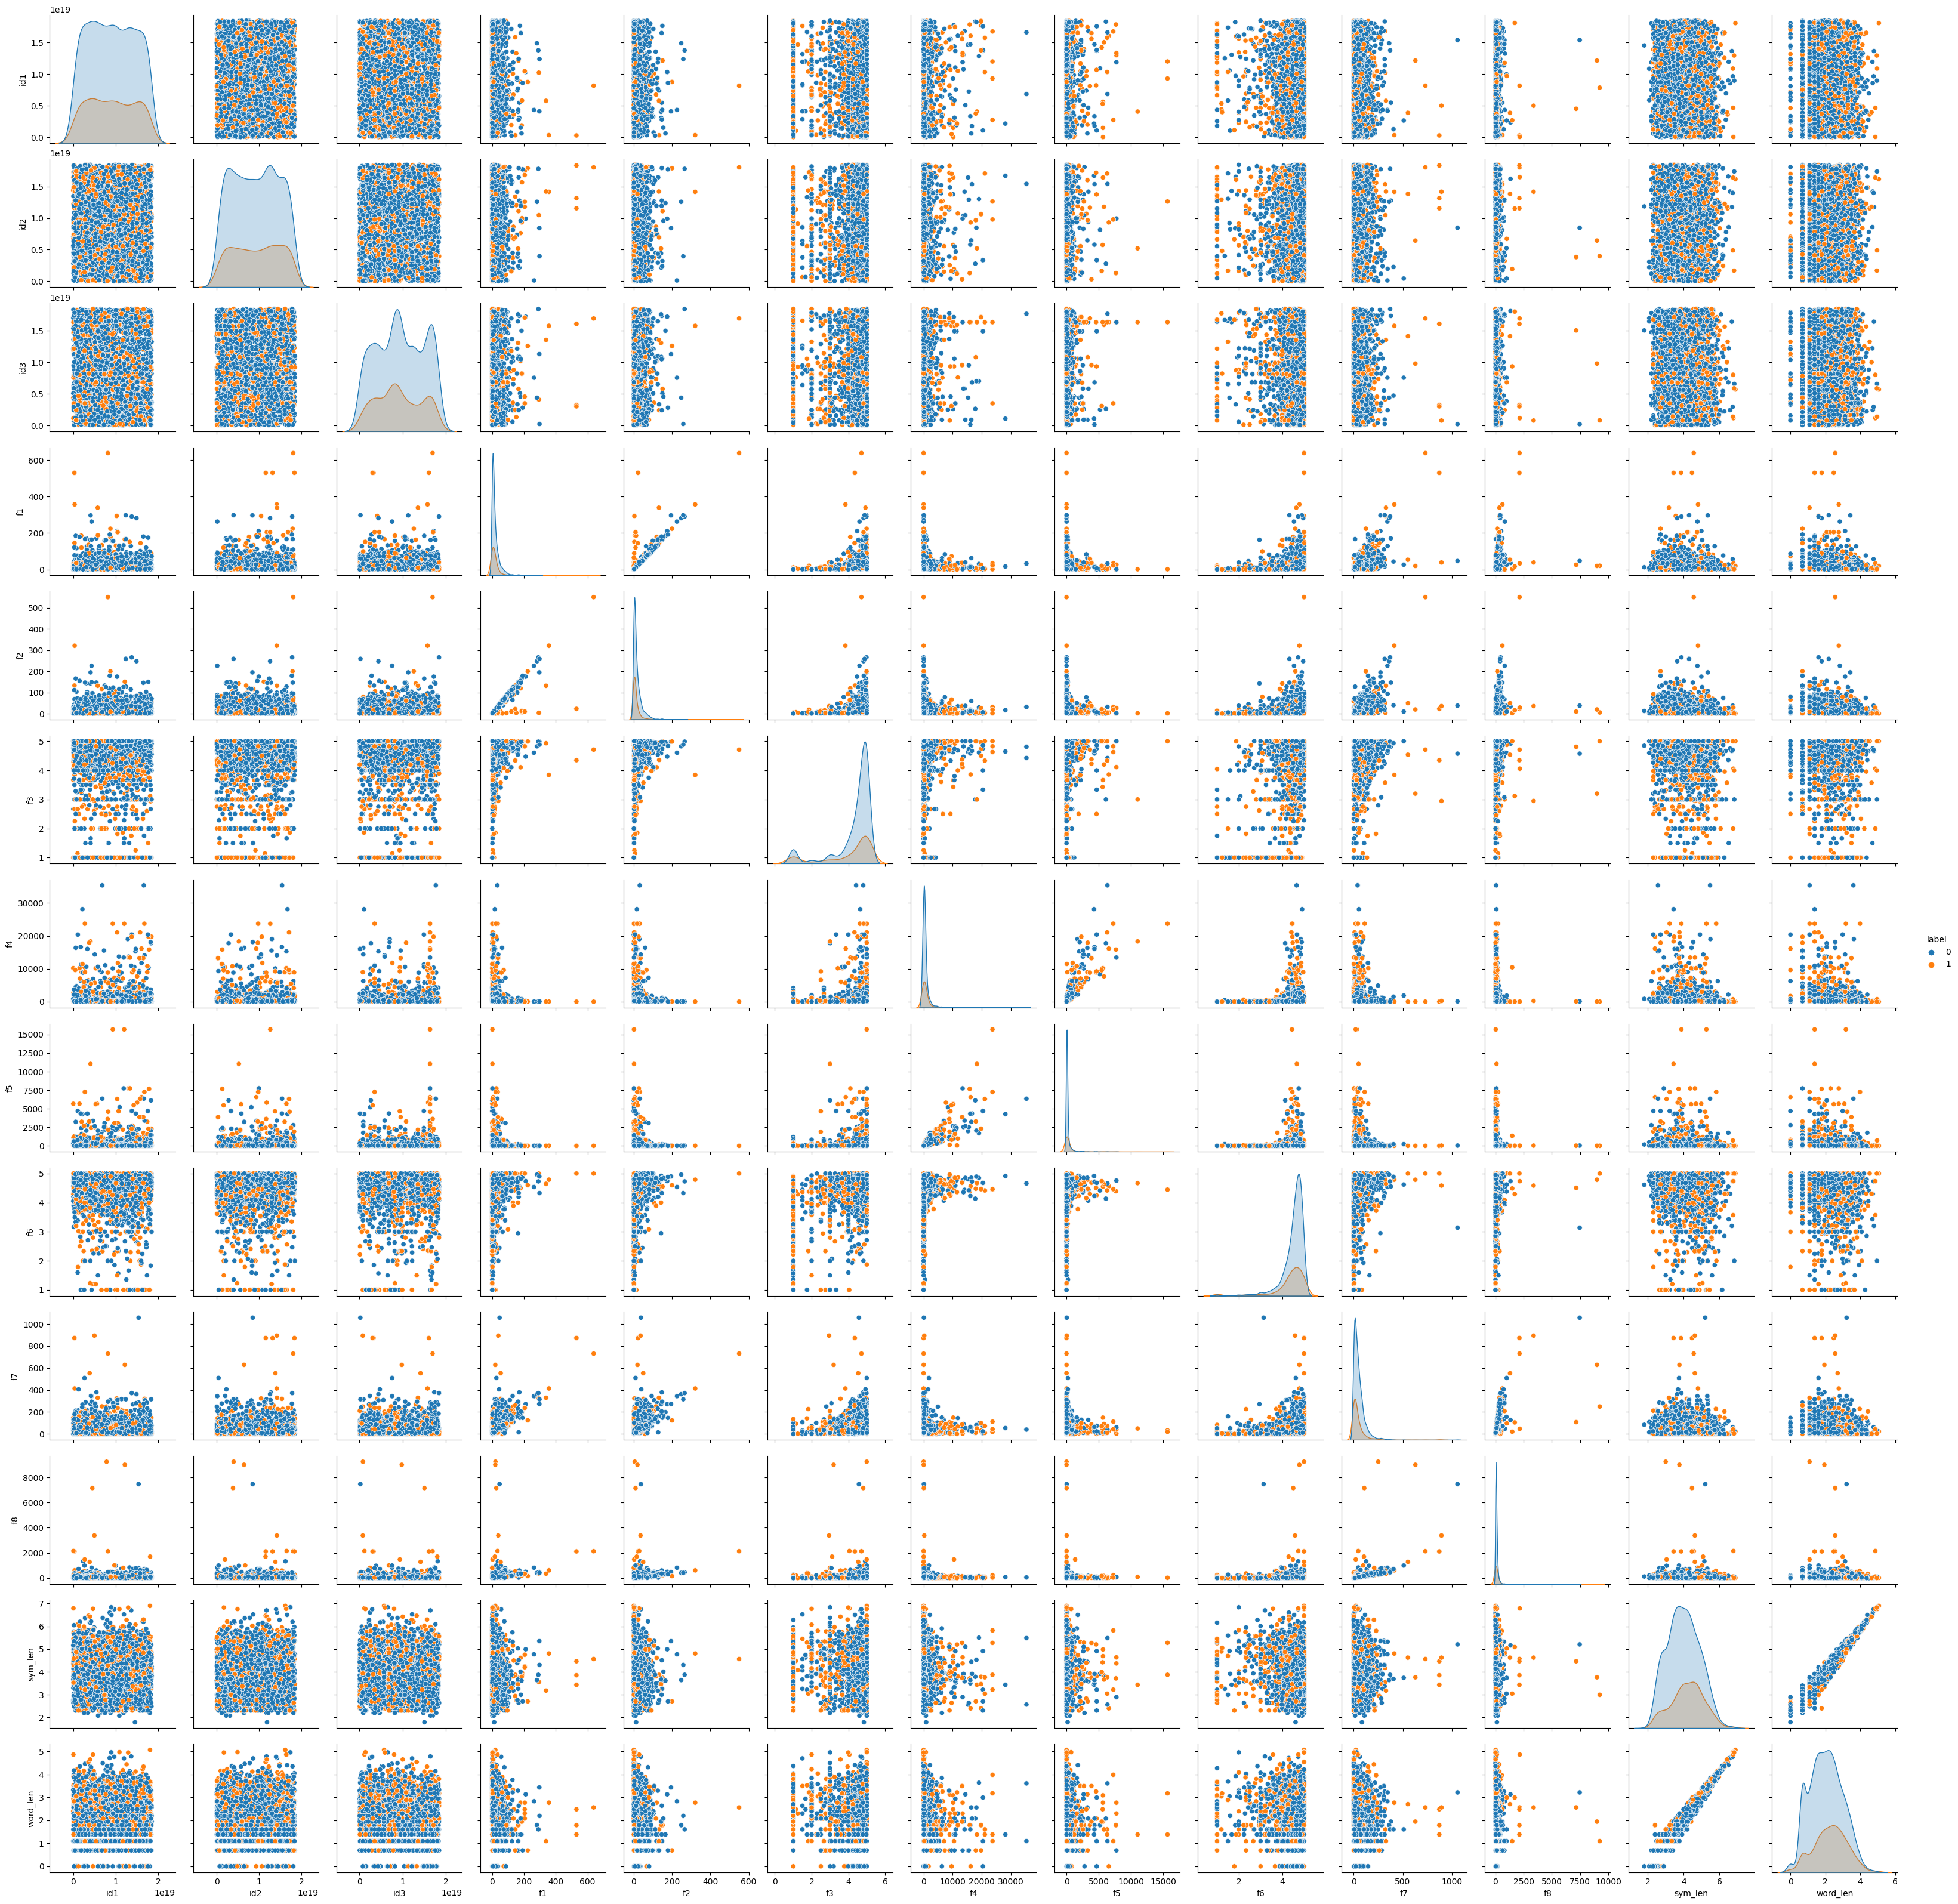

In [13]:
sns.pairplot(df, hue="label")
plt.show()

In [14]:
np.seterr(divide = 'ignore') 
df['log_f1'] = np.log(df['f1'])
df['log_f2'] = np.log(df['f2'])
df['log_f4'] = np.log(df['f4'])
df['log_f5'] = np.log(df['f5'])
df['log_f7'] = np.log(df['f7'])
df['log_f8'] = np.log(df['f8'])

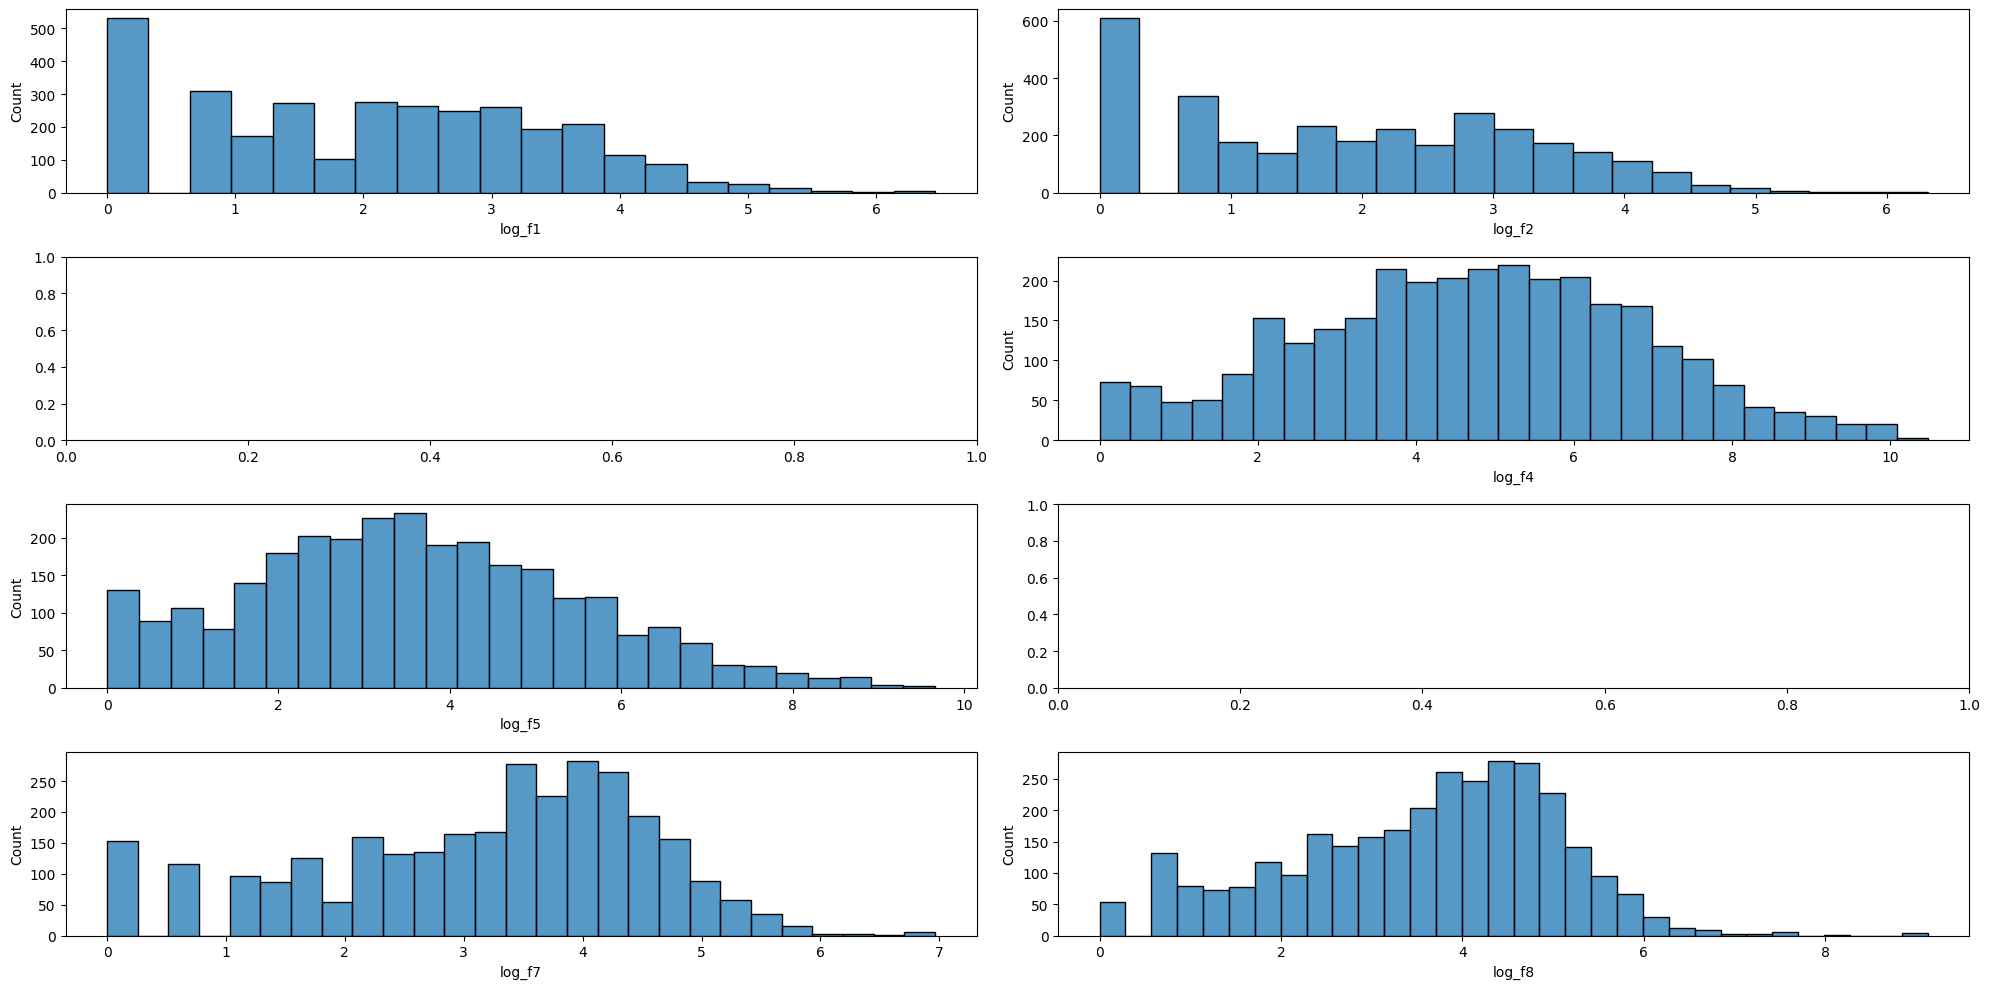

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
sns.histplot(data=df.log_f1, ax=axes[0,0])
sns.histplot(data=df.log_f2, ax=axes[0,1])
sns.histplot(data=df.log_f4, ax=axes[1,1])
sns.histplot(data=df.log_f5, ax=axes[2,0])
sns.histplot(data=df.log_f7, ax=axes[3,0])
sns.histplot(data=df.log_f8, ax=axes[3,1])
plt.xticks()
plt.tight_layout()
plt.show()

In [16]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return (remove_stopwords(lemmas))

In [ ]:
lemmas = list(tqdm(map(clean_text, df['text']), total=len(df)))
df['lemmas'] = lemmas

 14%|█████▎                                 | 429/3123 [00:01<00:09, 277.06it/s]

In [ ]:
df['lemmas'].sample(5)

In [ ]:
w2v_model = Word2Vec(sentences=lemmas,
                     min_count=3, 
                     window=1, 
                     vector_size=100,
                     sg=0)

w2v_model.train(lemmas, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)

In [ ]:
w2v_model.wv.most_similar("хороший")

In [ ]:
w2v_model.wv.most_similar("ужасный")

In [ ]:
def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    # apply TSNE 
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    fig.show()
    return fig


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

plot = plot_embeddings(x_vals, y_vals, labels)

In [ ]:
vectors = []

In [ ]:
vect = np.zeros(100)
for elem in lemmas:
    for word in elem:
        if word in w2v_model.wv.key_to_index:
            vect += np.array(w2v_model.wv.get_vector(word))
    if len(elem) != 0:
        vect /= len(elem)
    vectors.append(vect)
    vect = np.zeros(100)

In [ ]:
df['vectors'] = vectors

In [ ]:
df